<a href="https://colab.research.google.com/github/geoaigroup/models-deployment/blob/main/scripts/process_large_tiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML4CV project work

Summary: Improving and explaining instance segmentation on a litter detection dataset

Members:
- Dell'Olio Domenico
- Delvecchio Giovanni Pio
- Disabato Raffaele

The project was developed in order to improve instance segmentation results on the [TACO Dataset](http://tacodataset.org/).

We decided to implement and test various architectures, among the highest scoring on COCO instance segmentation datasets, in order to compare their performances.
We also tested some explainability methods on these models to try and explain model predictions.

## This notebook contains:
- Wrapper of the MaskDINO model that merges the instance segmentation masks,
casting the instance segmentation task to a semantic segmentation task
- Calls to compute the eigen-cam for semantic segmentation, with the purpose of visualization of the most salient features for the segmentation of images of the validation set

In [1]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git@5aeb252b194b93dc2879b4ac34bc51a31b5aee13'
%cd /content/
!git clone https://github.com/DomMcOyle/TACO-expl.git
%cd /content/TACO-expl
!git checkout maskdino
!git pull origin maskdino
%cd /content/TACO-expl/MaskDINO
!pip install -r requirements.txt
%cd /content/TACO-expl/MaskDINO/maskdino/modeling/pixel_decoder/ops
!sh make.sh
%cd /content/

  Cloning https://github.com/facebookresearch/detectron2.git (to revision 5aeb252b194b93dc2879b4ac34bc51a31b5aee13) to /tmp/pip-req-build-brgyagsa
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-brgyagsa
  Running command git rev-parse -q --verify 'sha^5aeb252b194b93dc2879b4ac34bc51a31b5aee13'
  Running command git fetch -q https://github.com/facebookresearch/detectron2.git 5aeb252b194b93dc2879b4ac34bc51a31b5aee13
  Running command git checkout -q 5aeb252b194b93dc2879b4ac34bc51a31b5aee13
  Resolved https://github.com/facebookresearch/detectron2.git to commit 5aeb252b194b93dc2879b4ac34bc51a31b5aee13
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.3 MB/s eta 0

/content
Cloning into 'TACO-expl'...
remote: Enumerating objects: 2468, done.
remote: Counting objects: 100% (630/630), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 2468 (delta 514), reused 564 (delta 470), pack-reused 1838
Receiving objects: 100% (2468/2468), 184.41 MiB | 32.05 MiB/s, done.
Resolving deltas: 100% (1282/1282), done.
/content/TACO-expl
Branch 'maskdino' set up to track remote branch 'maskdino' from 'origin'.
Switched to a new branch 'maskdino'
From https://github.com/DomMcOyle/TACO-expl
 * branch            maskdino   -> FETCH_HEAD
Already up to date.
/content/TACO-expl/MaskDINO
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 kB 2.6 MB/s eta 0:00:00
/content/TACO-expl/MaskDINO/maskdino/modeling/pixel_decoder/ops
running build
running build_py
creating build
creating build/lib.linux-x86_64-cpython-310
creating build/lib.linux-x86_64-cpython-310/functions
copying functions/ms_deform_attn_func.py -> build/lib.linux-x86_64-cpython-310/funct

In [2]:
from google.colab import drive
drive.mount("/content/MyDrive/", force_remount = True)

Mounted at /content/MyDrive/


In [3]:
!git clone https://github.com/geoaigroup/GEOAI-ECRS2023.git
!pip install segmentation-models-pytorch
!pip install rasterio
!pip install geopandas
%cd "/content/GEOAI-ECRS2023/Extending CAM-based XAI methods for Remote Sensing Imagery Segmentation"
!pwd
!pip install ttach
!pip install grad-cam

Cloning into 'GEOAI-ECRS2023'...
remote: Enumerating objects: 1040, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 1040 (delta 79), reused 24 (delta 24), pack-reused 937
Receiving objects: 100% (1040/1040), 255.54 MiB | 17.25 MiB/s, done.
Resolving deltas: 100% (549/549), done.
Updating files: 100% (177/177), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16429 sha256=c47f705ddc5405bb40045de53d6e24b19818704fd9eecf55194a8920d58070a5
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Cre

In [6]:
!mv "/content/TACO-expl/visual_utils.py" "/content/GEOAI-ECRS2023/Extending CAM-based XAI methods for Remote Sensing Imagery Segmentation"
%cd "/content/GEOAI-ECRS2023/Extending CAM-based XAI methods for Remote Sensing Imagery Segmentation"
!mv utils.py geo_utils.py

mv: cannot stat '/content/TACO-expl/visual_utils.py': No such file or directory
/content/GEOAI-ECRS2023/Extending CAM-based XAI methods for Remote Sensing Imagery Segmentation
mv: cannot stat 'utils.py': No such file or directory


## Note Well
After executing the above cells, the runtime has to be restarted

In [5]:
import torch, detectron2
%cd /content/
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import sys
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

sys.path.append('/content/TACO-expl/MaskDINO/maskdino/')
from config import add_maskdino_config
%cd /content/TACO-expl/MaskDINO/maskdino/
from detectron2.projects.deeplab import add_deeplab_config
from maskdino import MaskDINO
%cd /content/


%cd /content/TACO-expl/
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

import os.path
import json
import argparse
import numpy as np
import random
import datetime as dt
import copy
import torch.nn as nn
from sklearn.model_selection import train_test_split
from pathlib import Path

import torch
import math
import torch.utils.data
from torch.utils.data import DataLoader
from pycocotools import mask as coco_mask

from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog

%cd "/content/GEOAI-ECRS2023/Extending CAM-based XAI methods for Remote Sensing Imagery Segmentation"
from visual_utils import *

/content
/content/TACO-expl/MaskDINO/maskdino
/content
/content/TACO-expl
/content/GEOAI-ECRS2023/Extending CAM-based XAI methods for Remote Sensing Imagery Segmentation


## Dataset Loading

Here we load the dataset and we inspect the first entry from the validation set

In [7]:
keep_categories = ["Bottle", "Bottle cap", "Can", "Cigarette", "Cup",
                   "Lid", "Plastic bag & wrapper", "Pop tab", "Straw"]

def create_map(original, keep_supercategories):
  class_map = {}
  for cat in original:
    if cat["supercategory"] in keep_supercategories:
      class_map[cat["name"]] = cat["supercategory"]
    else:
      class_map[cat["name"]] = "Other"
  return class_map

def replace_dataset_classes(dataset, class_map):
      """ Replaces classes of dataset based on a dictionary"""
      class_new_names = list(set(class_map.values()))
      class_new_names.sort()
      class_originals = copy.deepcopy(dataset['categories'])
      dataset['categories'] = []
      class_ids_map = {}  # map from old id to new id

      # Assign background id 0
      has_background = False
      if 'Background' in class_new_names:
          if class_new_names.index('Background') != 0:
              class_new_names.remove('Background')
              class_new_names.insert(0, 'Background')
          has_background = True

      # Replace categories
      for id_new, class_new_name in enumerate(class_new_names):
          # Make sure id:0 is reserved for background
          id_rectified = id_new
          if not has_background:
              id_rectified += 1

          category = {
              'supercategory': '',
              'id': id_rectified,  # Background has id=0
              'name': class_new_name,
          }
          dataset['categories'].append(category)
          # Map class names
          for class_original in class_originals:
              if class_map[class_original['name']] == class_new_name:
                  class_ids_map[class_original['id']] = id_rectified

      # Update annotations category id tag
      for ann in dataset['annotations']:
          ann['category_id'] = class_ids_map[ann['category_id']]

In [22]:
with open("/content/TACO-expl/data/annotations_off_0_train.json", "r") as f:
    dataset = json.loads(f.read())
classes = [elem["name"] for elem in dataset["categories"]]

In [9]:
train_annotation_file = '/content/TACO-expl/data/annotations_off_0_train.json'
val_annotation_file = '/content/TACO-expl/data/annotations_off_0_resval.json'

img_dir_train = '/content/MyDrive/MyDrive/res_official/rot_train/'
img_dir_val = '/content/MyDrive/MyDrive/res_official/res_val/'

register_coco_instances("TACO_train", {}, train_annotation_file, img_dir_train)
MetadataCatalog.get("TACO_train").set(thing_classes = classes)
dataset_dicts_train = DatasetCatalog.get("TACO_train")

register_coco_instances("TACO_val", {}, val_annotation_file, img_dir_val)
MetadataCatalog.get("TACO_val").set(thing_classes = classes)
dataset_dicts_val = DatasetCatalog.get("TACO_val")

[06/13 15:08:47 d2.data.datasets.coco]: Loaded 1200 images in COCO format from /content/TACO-expl/data/annotations_off_0_train.json
[06/13 15:08:47 d2.data.datasets.coco]: Loaded 150 images in COCO format from /content/TACO-expl/data/annotations_off_0_resval.json


In [10]:
first_entry = dataset_dicts_val[0]
first_entry_img = cv2.imread(first_entry["file_name"])

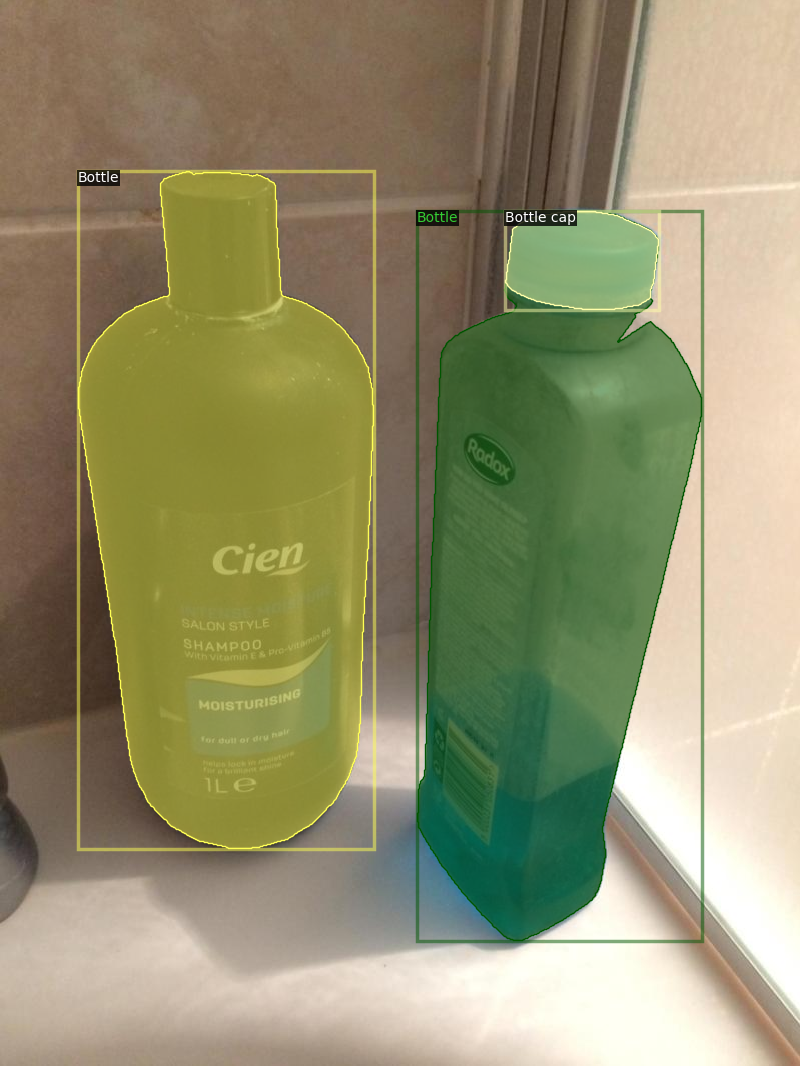

In [11]:
from detectron2.utils.visualizer import Visualizer
d2_visualizer = Visualizer(first_entry_img, MetadataCatalog.get("TACO_val"))
d2_visualizer = d2_visualizer.draw_dataset_dict(first_entry)
cv2_imshow(d2_visualizer.get_image())

## MaskDINO model loading

Here we load the MaskDINO model with the configurations employed during training.

### Side note:
It is possible to set
- train_cfg_loaded.MODEL.MaskDINO.TEST.INSTANCE_ON = False
- train_cfg_loaded.MODEL.MaskDINO.TEST.SEMANTIC_ON = True

and load the weights of the MaskDINO model optimized for instance segmentation,
to obtain a model that gives as output segmentation masks, however this is just a tweak and results are not guaranteed to be coherent with what has been learned in the other task. This has been proved by analyzing the prediction of the tweaked network and observing that segmentation masks for classes that were missing in the image were non-null.

In [12]:
train_cfg_loaded = get_cfg()
train_cfg_loaded.set_new_allowed(True)
train_cfg_loaded.merge_from_file("/content/TACO-expl/maskdino_config/taco_train_maskdino.yaml")
print(train_cfg_loaded.MODEL.BACKBONE.FREEZE_AT)
print(train_cfg_loaded.SOLVER.IMS_PER_BATCH)
print(train_cfg_loaded.INPUT.MIN_SIZE_TRAIN)
print(train_cfg_loaded.DATASETS.PRECOMPUTED_PROPOSAL_TOPK_TRAIN)
print(train_cfg_loaded.TEST.AUG.ENABLED)
print(train_cfg_loaded.INPUT.MASK_FORMAT)
print(train_cfg_loaded.Default_loading)
print(train_cfg_loaded.MODEL.MaskDINO.TEST.INSTANCE_ON) # it was previously set to true
print(train_cfg_loaded.MODEL.MaskDINO.TEST.SEMANTIC_ON) # it was previously set to false

0
2
(480, 512, 544, 576, 608, 640, 672, 704, 736, 768, 800)
100
False
polygon
False
True
False


In [13]:
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer

maskdino_model = build_model(train_cfg_loaded)
model_weights_path = "/content/MyDrive/MyDrive/MaskDINO_chkpts/model_final_freeze0.pth"
checkpointer = DetectionCheckpointer(maskdino_model)
checkpointer.load(model_weights_path)

criterion.weight_dict  {'loss_ce': 4.0, 'loss_mask': 5.0, 'loss_dice': 5.0, 'loss_bbox': 5.0, 'loss_giou': 2.0, 'loss_ce_interm': 4.0, 'loss_mask_interm': 5.0, 'loss_dice_interm': 5.0, 'loss_bbox_interm': 5.0, 'loss_giou_interm': 2.0, 'loss_ce_dn': 4.0, 'loss_mask_dn': 5.0, 'loss_dice_dn': 5.0, 'loss_bbox_dn': 5.0, 'loss_giou_dn': 2.0, 'loss_ce_interm_dn': 4.0, 'loss_mask_interm_dn': 5.0, 'loss_dice_interm_dn': 5.0, 'loss_bbox_interm_dn': 5.0, 'loss_giou_interm_dn': 2.0, 'loss_ce_0': 4.0, 'loss_mask_0': 5.0, 'loss_dice_0': 5.0, 'loss_bbox_0': 5.0, 'loss_giou_0': 2.0, 'loss_ce_interm_0': 4.0, 'loss_mask_interm_0': 5.0, 'loss_dice_interm_0': 5.0, 'loss_bbox_interm_0': 5.0, 'loss_giou_interm_0': 2.0, 'loss_ce_dn_0': 4.0, 'loss_mask_dn_0': 5.0, 'loss_dice_dn_0': 5.0, 'loss_bbox_dn_0': 5.0, 'loss_giou_dn_0': 2.0, 'loss_ce_interm_dn_0': 4.0, 'loss_mask_interm_dn_0': 5.0, 'loss_dice_interm_dn_0': 5.0, 'loss_bbox_interm_dn_0': 5.0, 'loss_giou_interm_dn_0': 2.0, 'loss_ce_1': 4.0, 'loss_mask_1':

{'trainer': {'iteration': 5747,
  'hooks': {'LRScheduler': {'base_lrs': [1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     1e-05,
     0.0001,
     0.0001,
     0.0001,
     0.0001,
     0.0001,
     0.0001,
     0.0001,
     0.0001,
     0.0001,
     0.0001,
     0.0001,
     0.0001,
     0.0001,
     0.0001,
     0.0001,
     0.0001,
     0.0001,
     0.0001,
     0.0001,
     0.0001,
     0.0001,
     0.0001,
     0.000

Here we analyze the raw outcome of a prediction to check which tensors have gradients or gradient functions.
Unfortunately, the instance segmentation masks have none of them.

In [14]:
maskdino_model.eval()
with torch.no_grad():
  height, width = first_entry_img.shape[:2]
  image = torch.as_tensor(first_entry_img.astype("float32").transpose(2, 0, 1))
  image.to("cuda:0")
  inputs = {"image": image, "height": height, "width": width}
  print(inputs["image"].shape)
  predictions = maskdino_model([inputs])[0]

print(predictions)

torch.Size([3, 1066, 800])
{'instances': Instances(num_instances=100, image_height=1066, image_width=800, fields=[pred_masks: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0

In [15]:
def visualize_mask(single_mask):
  plt.figure(figsize=(10, 10))
  plt.imshow(single_mask)
  plt.colorbar()
  plt.axis('off')
  plt.show()

## Merging of the masks

In the following cells we aim to modify the raw output of the MaskDINO model to obtain a semantic segmentation mask.

To do so, we need perform a classwise logical or of the instance segmentation
masks.

In [16]:
print(predictions.keys())
print(predictions["instances"].get_fields().keys())
all_instance_masks = predictions["instances"].get_fields()["pred_masks"]
all_instance_scores = predictions["instances"].get_fields()["scores"]
all_instance_classes = predictions["instances"].get_fields()["pred_classes"]

th_score_idx = np.where(all_instance_scores.cpu() > 0.20)
th_masks = all_instance_masks[th_score_idx, :, :]
th_classes = all_instance_classes[th_score_idx]
n_classes = len(classes)
print(th_score_idx)
print(th_masks.shape)
print(th_classes)
print(n_classes)

dict_keys(['instances'])
dict_keys(['pred_masks', 'pred_boxes', 'scores', 'pred_classes'])
(array([ 0, 10, 20, 26, 31]),)
torch.Size([1, 5, 1066, 800])
tensor([0, 0, 0, 6, 1], device='cuda:0')
10


In [17]:
def merge_masks(th_masks, th_classes, n_classes):
  masks = th_masks.squeeze(0)
  height, width = masks.shape[1:]
  print(height, width)
  merged = np.zeros((n_classes, height, width))
  for idx, single_mask in enumerate(masks):
    merged[th_classes[idx]] = np.logical_or(merged[th_classes[idx]], single_mask)
  merged = np.expand_dims(merged, 0)
  return merged

merged = merge_masks(th_masks.cpu(), th_classes.cpu(), n_classes)
print(merged.shape)

1066 800
(1, 10, 1066, 800)


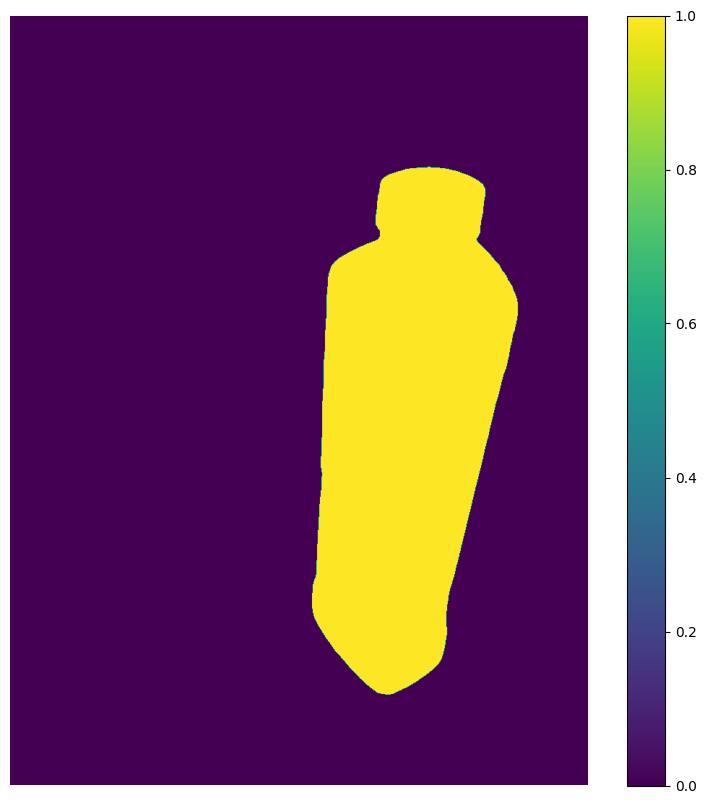

In [18]:
# Visualization of the first instance semgentation mask
visualize_mask(th_masks[0, 0, :, :].cpu())

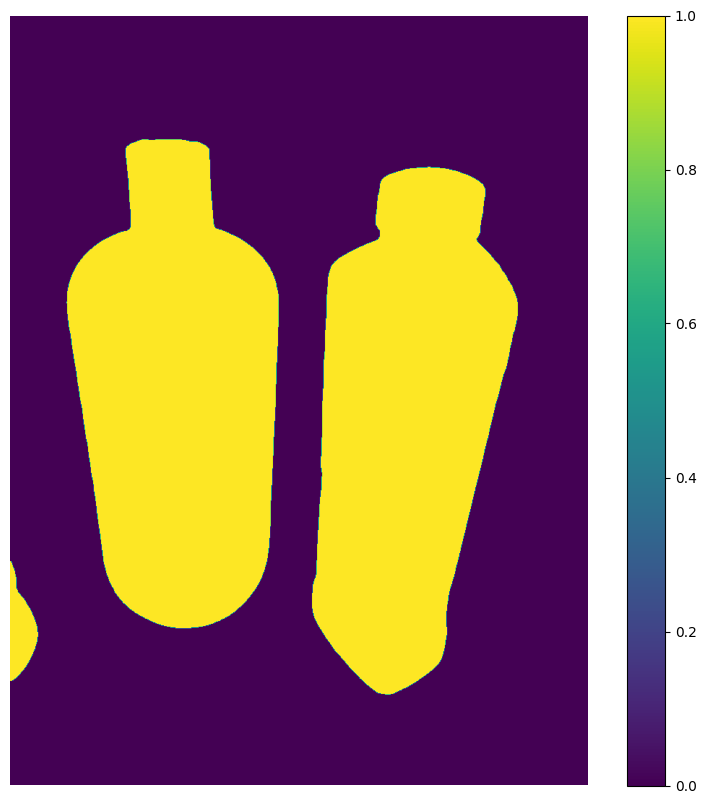

In [19]:
# visualization of the first semantic segmentation mask
# (merged version of the above object th_masks)
visualize_mask(merged[0, 0, :, :])

## Layer selection

With the aim of applying CAM methods to our semantic segmentation masks,
we need to select certain layers of the backbone (ResNet50), which will be used to produce the maps of the most salient features for the purpose of the segmentation task.

### Side Note:

Some experiments have been carried out with specific layers, but the outcome was negative for various reasons, here we report the most salient ones:
- `backbone.res2.2` is not a valid choice as we get OOM due to the large size of the activation;
- `sem_seg_head.pixel_decoder.input_proj`, `sem_seg_head.predictor.decoder.ref_point_head` and `sem_seg_head.predictor.decoder.layers` cannot be employed due to the different datatype of the weights (`the exact error is ufunc 'isnan' not supported for the input types`)

In [26]:
#print(maskdino_model.parameters)

target_layers_backbone_5 = [maskdino_model.get_submodule("backbone.res5.2")]
target_layers_backbone_4 = [maskdino_model.get_submodule("backbone.res4.2")]
target_layers_backbone_3 = [maskdino_model.get_submodule("backbone.res3.2")]
target_layers_backbone_5_4 = [maskdino_model.get_submodule("backbone.res4.2"), maskdino_model.get_submodule("backbone.res5.2")]
target_layers_backbone_5_4_3 = [maskdino_model.get_submodule("backbone.res3.2"),
                                maskdino_model.get_submodule("backbone.res4.2"),
                                maskdino_model.get_submodule("backbone.res5.2")]

In [32]:
from torch.autograd import Variable
import pdb


class DummyDino_seg(nn.Module):
  def __init__(self, dino_model):
    super().__init__()
    self.dino_model = dino_model

  def forward(self, x):
    height = x.shape[-2]
    width = x.shape[-1]
    to_pass = [{"image": x.squeeze(0), "height": height, "width": width}]
    #print(to_pass["image"].shape)
    output = [self.dino_model(to_pass)[0]["sem_seg"]]
    return output

class DummyDino(nn.Module):
  def __init__(self, dino_model, n_classes):
    super().__init__()
    self.dino_model = dino_model
    self.n_classes = n_classes

  def merge_masks(self, th_masks, th_classes):
    masks = th_masks.squeeze(0)
    height, width = masks.shape[1:]
    merged = np.zeros((self.n_classes, height, width))
    for idx, single_mask in enumerate(masks):
      merged[th_classes[idx]] = np.logical_or(merged[th_classes[idx]], single_mask.cpu().numpy())
    merged = torch.tensor(merged).unsqueeze(0).cuda()
    return merged

  def forward(self, x):
    height = x.shape[-2]
    width = x.shape[-1]
    to_pass = [{"image": x.squeeze(0), "height": height, "width": width}]
    output = self.dino_model(to_pass)[0]
    all_instance_masks = output["instances"].get_fields()["pred_masks"]
    all_instance_scores = output["instances"].get_fields()["scores"]
    all_instance_classes = output["instances"].get_fields()["pred_classes"]
    th_score_idx = torch.where(all_instance_scores > 0.20)[0]
    th_masks = all_instance_masks[th_score_idx, :, :]
    th_classes = all_instance_classes[th_score_idx]
    seg_mask = self.merge_masks(th_masks, th_classes)
    return torch.tensor(seg_mask).cuda()

In [35]:
maskdino_model.eval()
wrapped_dino = DummyDino(maskdino_model, 10)
input_image = totensor(first_entry_img).cuda().requires_grad_()
output = wrapped_dino(input_image)

In [50]:
target_mask_float = np.float32(output[0, 0, :, :].detach().cpu().numpy())
print(target_mask_float.shape)

(1066, 800)


## EigenCAM plots

A peculiarity that has been found while using these transformer-based models and this type of CAM methods that does not require gradients is that the maps highlight everything but the objects of interest.

This inversion of trend differs from what stated in the [paper](https://https://arxiv.org/pdf/2008.00299), even because the class alone doesn't seem to influence the whole outcome.

running seg-grad-cam...
building activation list...
building gradient list...
Activations list size:  1
Gradients list size:  0
Target layer size:  1
in the loop...


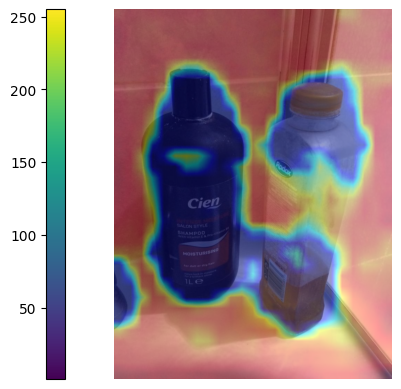

In [51]:
# if we write any number different from 0 as first argument, the outcome is the same
targets = [SemanticSegmentationTarget(0, target_mask_float)]

print('running seg-grad-cam...')
with GRADCAM_Extensions(extension = "eigen_cam", model=wrapped_dino, target_layers = target_layers_backbone_5, use_cuda=torch.cuda.is_available(), uses_gradients = False) as eigencam:
    grayscale_cam_EX_5 = eigencam(input_tensor=input_image, targets=targets)[0, :]

grayscale_cam_EX_5.shape
[Exmap_sgc, heatmap_sgc_rgba] = show_cam_image_whu(first_entry_img, grayscale_cam_EX_5, 0.006)
plt.imshow(Exmap_sgc)
plt.axis('off')
plt.colorbar(location='left')

running seg-grad-cam...
building activation list...
building gradient list...
Activations list size:  1
Gradients list size:  0
Target layer size:  1
in the loop...


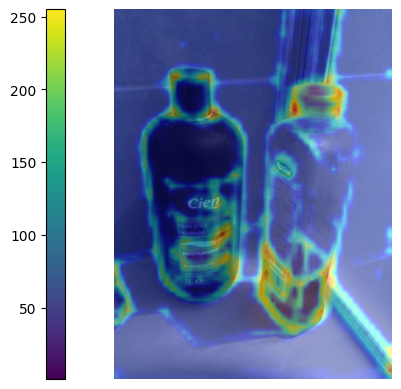

In [43]:
targets = [SemanticSegmentationTarget(0, target_mask_float)]

print('running seg-grad-cam...')
with GRADCAM_Extensions(extension = "eigen_cam", model=wrapped_dino, target_layers = target_layers_backbone_4, use_cuda=torch.cuda.is_available(), uses_gradients = False) as eigencam:
    grayscale_cam_EX_4 = eigencam(input_tensor=input_image, targets=targets)[0, :]

grayscale_cam_EX_4.shape
[Exmap_sgc, heatmap_sgc_rgba] = show_cam_image_whu(first_entry_img, grayscale_cam_EX_4, 0.006)
plt.imshow(Exmap_sgc)
plt.axis('off')
plt.colorbar(location='left')

running seg-grad-cam...
building activation list...
building gradient list...
Activations list size:  1
Gradients list size:  0
Target layer size:  1
in the loop...


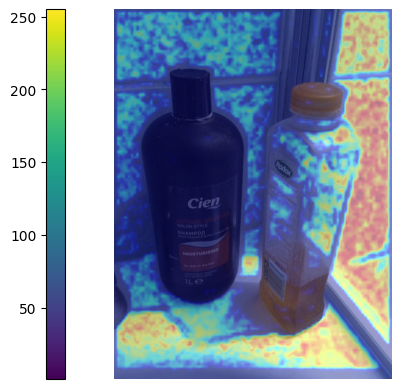

In [44]:
targets = [SemanticSegmentationTarget(0, target_mask_float)]

print('running seg-grad-cam...')
with GRADCAM_Extensions(extension = "eigen_cam", model=wrapped_dino, target_layers = target_layers_backbone_3, use_cuda=torch.cuda.is_available(), uses_gradients = False) as eigencam:
    grayscale_cam_EX_3 = eigencam(input_tensor=input_image, targets=targets)[0, :]

grayscale_cam_EX_3.shape
[Exmap_sgc, heatmap_sgc_rgba] = show_cam_image_whu(first_entry_img, grayscale_cam_EX_3, 0.006)
plt.imshow(Exmap_sgc)
plt.axis('off')
plt.colorbar(location='left')

running seg-grad-cam...
building activation list...
building gradient list...
Activations list size:  2
Gradients list size:  0
Target layer size:  2
in the loop...
in the loop...


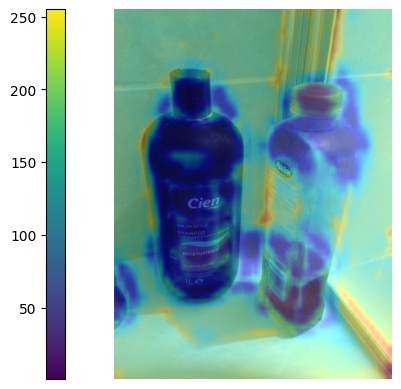

In [45]:
targets = [SemanticSegmentationTarget(0, target_mask_float)]

print('running seg-grad-cam...')
with GRADCAM_Extensions(extension = "eigen_cam", model=wrapped_dino, target_layers = target_layers_backbone_5_4, use_cuda=torch.cuda.is_available(), uses_gradients = False) as eigencam:
    grayscale_cam_EX_5_4 = eigencam(input_tensor=input_image, targets=targets)[0, :]

grayscale_cam_EX_5_4.shape
[Exmap_sgc, heatmap_sgc_rgba] = show_cam_image_whu(first_entry_img, grayscale_cam_EX_5_4, 0.006)
plt.imshow(Exmap_sgc)
plt.axis('off')
plt.colorbar(location='left')

running seg-grad-cam...
building activation list...
building gradient list...
Activations list size:  3
Gradients list size:  0
Target layer size:  3
in the loop...
in the loop...
in the loop...


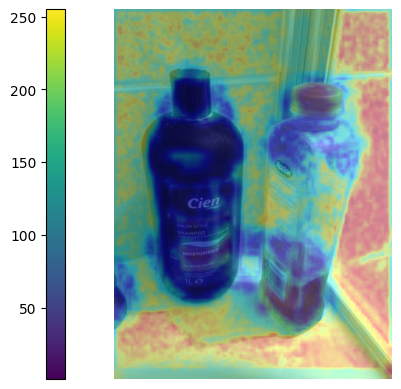

In [47]:
targets = [SemanticSegmentationTarget(0, target_mask_float)]

print('running seg-grad-cam...')
with GRADCAM_Extensions(extension = "eigen_cam", model=wrapped_dino, target_layers = target_layers_backbone_5_4_3, use_cuda=torch.cuda.is_available(), uses_gradients = False) as eigencam:
    grayscale_cam_EX_5_4_3 = eigencam(input_tensor=input_image, targets=targets)[0, :]

grayscale_cam_EX_5_4_3.shape
[Exmap_sgc, heatmap_sgc_rgba] = show_cam_image_whu(first_entry_img, grayscale_cam_EX_5_4_3, 0.006)
plt.imshow(Exmap_sgc)
plt.axis('off')
plt.colorbar(location='left')